# Notes

Task: Please review the dataset and start outlining the way you would go about the model-building process with the goal of predicting the probability that a player will win a foul on his possession after he receives or recovers the ball.

Notes:
- In the case of a received pass, the previous event (related event) is to be inspected for the pass attributes (location, length, highness...)
- Aggregated player data could be useful (ratio of passes under pressure signaling if he waits for pressure, dribbles per match)
- Referees are really important
- Home or away
- (Game state)


Cooridnates
- I suspect the origo is different for the two teams competing

# Dependencies

In [130]:
import pandas as pd
import numpy as np

from typing import Tuple
from mplsoccer import Pitch
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.utils import resample
from hdbscan import HDBSCAN
from umap.umap_ import UMAP
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from typing import Dict, List
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

## Custom functions

In [2]:
def extract_location(location_col: pd.Series) -> Tuple[pd.Series, pd.Series]:
    """
    The main purpose of this function is to bring the location columns to usable form
        Inputs:
            location_col (pd.Series): Pandas series containing location data.
        
        Returns:
            Tuple[pd.Series, pd.Series]: Extracted X, Y coordinates as two series.
    """
    splitted_cols = location_col.str.split(',', expand=True)
    loc_x, loc_y = splitted_cols.iloc[:, 0], splitted_cols.iloc[:, 1]
    loc_x = pd.to_numeric(loc_x, errors='coerce')
    loc_y = pd.to_numeric(loc_y, errors='coerce')
    
    return loc_x, loc_y

def add_in_M3(input_df: pd.DataFrame, x_name: str='x') -> pd.Series:
    return ((input_df[x_name]<=80) & (input_df[x_name]>=40)).astype(int)

def add_in_DBox(input_df: pd.DataFrame, x_name: str='x', y_name: str='x') -> pd.Series:
    return (((input_df[x_name]<=15) & (input_df[y_name]>=33) & (input_df[y_name]<=47) & (input_df[x_name]>=2))).astype(int)

def add_forward_pass(input_df: pd.DataFrame, pass_angle_name: str='pass.angle') -> pd.Series:
    return (input_df[pass_angle_name].between(-np.pi/4, np.pi/4)).astype(int)

def plot_histograms_grid(df, category_col, bins=None):
    # Number of columns (excluding category column)
    num_cols = len(df.columns) - 1  # Exclude the category column
    num_rows = int(np.ceil(num_cols / 4))  # Calculate number of rows needed for 4 columns per row

    fig, axes = plt.subplots(num_rows, 4, figsize=(15, 3 * num_rows))  # Create grid
    
    # Flatten axes for easy indexing
    axes = axes.flatten()
    
    for idx, col in enumerate(df.drop(columns=[category_col]).columns):
        ax = axes[idx]
        
        # Drop NaN values from the current column
        df_col = df.dropna(subset=[col])
        df_col = df.loc[df[col]!='NONE']

        # Plot histograms for each category in the column
        ax.hist(df_col[df_col[category_col] == 0][col],
                bins=bins,
                alpha=0.7, label='No foul', color='grey', density=True)
        ax.hist(df_col[df_col[category_col] == 1][col],
                bins=bins,
                alpha=0.5, label='Foul won', color='red', density=True)
        
        ax.set_title(col)  # Set title as column name
        ax.legend(prop={'size': 8})  # Adjust legend size
        ax.set_yticks([])
        ax.set_ylabel("")
    
    # Hide empty subplots if any
    for i in range(idx + 1, len(axes)):
        fig.delaxes(axes[i])
    

    plt.tight_layout()
    plt.show()

def plot_histogram_one(df_visu, category_col, content_col=None, density=False, bins=None):
    content_col = category_col if content_col is None else content_col
    df_visu = df_visu.dropna(subset=[category_col])  # Drop NaN values from the column
    
    plt.figure(figsize=(6, 4))
    
    # Plot histograms for each category
    plt.hist(df_visu[df_visu[category_col] == 0][content_col], alpha=0.7, label='No foul', color='grey',
             density=density, bins=bins)
    plt.hist(df_visu[df_visu[category_col] == 1][content_col], alpha=0.5, label='Foul won', color='red',
             density=density, bins=bins)

    plt.title(content_col)
    plt.legend(prop={'size': 8})
    plt.yticks([])
    plt.ylabel("")

    plt.show()


## Configs

In [3]:
to_boolean_cols = [
    'under_pressure',
    'under_pressure_related',
    'counterpress',
    'contains_foulwon'
]

to_string_cols = [
    'type.id',
    'play_pattern.id',
    'play_pattern.id_related',
    'team.id',
    'opponent_team.id',
    # 'team.id_related',  # useful with having opponent and own team id?
    'player.id',
    'position.id',
    'position.id_related',
    'pass.body_part.id',
    'pass.body_part.id_related',
    'pass.type.id',
    'pass.type.id_related',
    'duel.outcome.id',
    'stadium.id',
    'referee.id',
    'manager_id_opponent',
    'manager_id_own',
    'manager_countryid_opponent',
    'manager_countryid_own',
    'location_x_bin',
    'location_y_bin',
    'location_y_bin_width',
    'pass.height.id',
    'pass.height.id_related',
]

to_roundup_cols = [
    'pass.length',
    'pass.length_related',
    # 'location_x',
    # 'location_y'
]

# to_roundup2_cols = [
#     'pass.angle',
#     'pass.angle_related',
# ]


categorical_cols = [
    'contains_foulwon',
    'type.id',
    'play_pattern.id',
    'play_pattern.id_related',
    # 'team.id',
    # 'opponent_team.id',
    # # 'player.id',
    # 'position.id',
    # 'position.id_related',
    'pass.body_part.id',
    'pass.body_part.id_related',
    'pass.type.id',
    'pass.type.id_related',
    'duel.outcome.id',
    # 'stadium.id',
    'referee.id',
    # 'manager_id_opponent',
    # 'manager_id_own',
    'manager_countryid_opponent',
    'manager_countryid_own',
    'location_x_bin',
    # 'location_y_bin',
    'location_y_bin_width',
    'under_pressure',
    'under_pressure_related',
    # 'counterpress',
    'pass.height.id',
    'pass.height.id_related'
]

numerical_cols = [
    'pass.length',
    'pass.length_related',

 ]

# Data

## Data import

In [4]:
df_event = pd.read_csv('/Users/thomasregos/Owny/Assessment/Swish_Take_Home_Assessment_Data_-_EPL/epl_event_data_15.csv',
                    #    nrows=10000
                       )

df_matches = pd.read_csv('/Users/thomasregos/Owny/Assessment/Swish_Take_Home_Assessment_Data_-_EPL/epl_matches_15.csv')

## Data exploration

In [5]:
df_matches.columns

Index(['Unnamed: 0', 'match_id', 'match_date', 'kick_off', 'home_score',
       'away_score', 'match_status', 'last_updated', 'match_week',
       'competition.competition_id', 'competition.country_name',
       'competition.competition_name', 'season.season_id',
       'season.season_name', 'home_team.home_team_id',
       'home_team.home_team_name', 'home_team.managers',
       'away_team.away_team_id', 'away_team.away_team_name',
       'away_team.managers', 'competition_stage.id', 'competition_stage.name',
       'stadium.id', 'stadium.name', 'referee.id', 'referee.name',
       'referee.country.id', 'referee.country.name'],
      dtype='object')

In [6]:
df_event['type.name'].unique()

array(['Starting XI', 'Half Start', 'Pass', 'Ball Receipt*', 'Carry',
       'Pressure', 'Dispossessed', 'Duel', 'Shot', 'Block', 'Goal Keeper',
       'Ball Recovery', 'Miscontrol', 'Clearance', 'Dribbled Past',
       'Dribble', 'Interception', 'Foul Committed', 'Foul Won',
       'Half End', 'Substitution', 'Injury Stoppage', 'Tactical Shift',
       'Shield', '50/50', 'Offside', 'Error', 'Bad Behaviour',
       'Referee Ball-Drop', 'Own Goal Against', 'Own Goal For',
       'Player Off', 'Player On'], dtype=object)

In [7]:

# n = 1528

# bbb = df_event.iloc[max(n - 10, 0): min(n + 11, len(df_event))]

# Training dataset
The main goal is to create a table where all the starting actions of a mini possession is listed. Mini possession is part of a possession where all the actions are taken by the same player. These events then should be ammended with a target variable which signals that a mini possession contained a foul won or not. Additional variables are later added for more info about the event.

## Skeleton of the training dataset



Each row should be a mini possession of the player, which starts by receiving or recovering the ball. In order to identify the mini possessions a number is assigned to a player's events inside a possession. This number is different for all of the player's mini possessions. So if he received a pass then carried the ball and passed it, it will receive a number and then if inside the possession he receives the ball again these events will have a different number. Combining these mini possession IDs with the possession ID, match ID and the player ID all the mini possession can be identified.



Notes:

- Mini possessions have to be detected at player level
    - First the sub possession should be calculated and then create a matchid_possession_subpossession 
- For our purpose those mini possessions are relevant that start with ball recovery or received pass 
    - Valid mini possessions are identified by type.name as we have a better control this way. For detecting ball recovery it would be an option to check if the possession_team.name has changed but there are examples of making a recovery winning a foul and the data still says that the possession is on the other team (id: 7317). As the possession mechanics are not clear I will use type.name.
    - Sometimes a possession starts with a 'Foul Won'. I don't think we should include those as the probability of these possessions to contain a 'Foul Won' is certain.
    - type.name == 'Ball Recovery'
    - pass.type.name = 'Recovery'
        - If a recovery is also a pass. These could be also relevant if the pass provokes a hand ball.
    - type.name == 'Ball Receipt*'
        - Beware, there is an event for receiving an incomplete pass which was already intercepted, with type.name = 'Ball Receipt*'
        - ball_receipt.outcome.id = 9 (incomplete pass that was actually not received)
        - These should be None as they are not real mini possessions
    - type.name == 'Interception'
        - Although it is not a ball recovery by name and no instruction is given to include these, but I think this action recovers the ball in open play so it satisfies our criteria
    - type.name == 'Duel'
        - Although it is not a ball recovery by name and no instruction is given to include these, but I think this action recovers the ball in open play so it satisfies our criteria
    - type.name == 'Goal Keeper'
        - Although it is not a ball recovery by name and no instruction is given to include these, but I think this action recovers the ball in open play so it satisfies our criteria
    - type.name == 'Clearance'
        - Although it is not a ball recovery by name and no instruction is given to include these, but I think this action recovers the ball in open play so it satisfies our criteria
    - type.name == 'Block'
        - Although it is not a ball recovery by name and no instruction is given to include these, but I think this action recovers the ball in open play so it satisfies our criteria
- Getting rid of Pressure events
    - From our perspective it is enough to know if certain events were under pressure or not and it is reflected in the 'under_pressure' column
    - Getting rid of the individual 'Pressure' events enables us to have a chronological event chain for player possessions
- Getting rid of 'Foul Committed' events
    - type.name == 'Foul Committed'
    - Foul won is enough for our purpose
- Foul won
    - type.name == 'Foul Won'
    - It can happen that a player not having the ball draws the foul. (index: 646)
    - It can happen that a player having the ball commits a foul. (index: 898)
    - It might happen that a foul is won but the play goes on as I saw several examples of winning a foul and then having a carry event that starts at the same location. It is supported by the fact that this carry and the subsequent events are not labeled as 'play_pattern.name' = 'From Free Kick'. These could be when the referee plays advantage. As there is no info about how to consider these fouls that were won but ultimately not resulted in a freekick I will count them as a foul won. (index: 1012)


In [8]:
# Mini possessions
df_filtered = df_event.copy()

# - Getting rid of unneccessary rows
notvalid_start_events = ['Foul Committed', 'Pressure', 'Dribbled Past']
df_filtered = df_filtered[~df_filtered['type.name'].isin(notvalid_start_events)]

# - calculating mini_possessions inside possessions
# not perfect but we will be able to get a unique identifier for each mini possession
df_filtered['poss_mini'] = (
    df_filtered.groupby('possession')['player.id']
    .transform(lambda x: x.ne(x.shift()).cumsum())
)

# - adding unique identifier for mini possessions
df_filtered['poss_mini_id'] = df_filtered[['match_id', 'player.id', 'possession', 'poss_mini']].fillna('_').apply(lambda row: '_'.join(row.apply(lambda x: str(int(x)) if isinstance(x, float) and x.is_integer() else str(x))), axis=1)


# - identifying mini possessions that started with a ball recovery or a ball receipt
valid_start_events = ['Ball Recovery', 'Ball Receipt*', 'Duel', 'Interception', 'Goal Keeper', 'Clearance', 'Block']

df_filtered['valid_start'] = df_filtered.groupby('poss_mini_id')['type.name'].transform(
    lambda x: 1 if x.isin(valid_start_events).any() or (df_filtered.loc[x.index, 'pass.type.name'] == 'Recovery').any() else 0
)

# - identifying mini possession that contains Foul Won
df_filtered['contains_foulwon'] = df_filtered.groupby('poss_mini_id')['type.name'].transform(lambda x: 1 if 'Foul Won' in x.values else 0)


# - preserving only starting events of mini possessions
mask = ((df_filtered['valid_start']==1))
df_filtered = df_filtered[mask]

df_training_full = df_filtered.drop_duplicates(subset=['poss_mini_id'], keep='first')


## Additional info about the events



I only use data that is available at the time of the ball recovery or pass reception.

### Info about prior events

#### Checking the type of related events

Info about opponent or teammate passes might be useful.

Notes:
- Most of the related events are passes from a teammate or an opponent pass.
- Pressures are also above 1% but this info is reflected on the starting event's record itself.
- Opponent shots are around 2% of the whole related events, and they might be interesting for niche events, but not used at this time.


In [9]:
df_filtered_event = df_event.copy()
df_filtered = df_training_full.copy()

df_filtered_event['seconds_elapsed'] = df_filtered_event['minute'] * 60 + df_filtered_event['second']
df_filtered['seconds_elapsed'] = df_filtered['minute'] * 60 + df_filtered['second']

# Expanding related events into separate rows
df_exploded = df_filtered.assign(related_events=df_filtered['related_events'].str.split(', ')).explode('related_events')

# Merging with original data to get the related event details
df_merged = df_exploded.merge(df_filtered_event, left_on='related_events', right_on='id', how='left', suffixes=['', '_related'])

# Keeping only related events that happened before
df_valid = df_merged[df_merged['seconds_elapsed_related'] < df_merged['seconds_elapsed']]

# Differentiating between opponent and own related events
df_valid.loc[df_valid['team.id'] != df_valid['team.id_related'], 'type.name_related'] = (df_valid['type.name_related'].astype(str) + "_opp")

# Ratio of certain event types in the valid related events
rel_counts = df_valid['type.name_related'].value_counts(normalize=True)
print(rel_counts)


type.name_related
Pass             0.790014
Pass_opp         0.152689
Pressure_opp     0.038874
Shot_opp         0.018171
Shot             0.000134
Carry_opp        0.000072
Ball Receipt*    0.000045
Name: proportion, dtype: float64


#### Including data about related events

In [10]:
# preserving only the desired type of related events
df_valid = df_valid[df_valid['type.name_related'].isin(['Pass', 'Pass_opp'])]

# renaming important columns
df_valid = df_valid.rename(columns={'related_events': 'relevant_related_id'})

In [11]:

df_filtered = df_training_full.copy()

df_filtered['seconds_elapsed'] = df_filtered['minute'] * 60 + df_filtered['second']

# checking if there are no two relevant related events for an event
print(df_valid['id'].nunique() == df_valid.shape[0])

# merging the relevant related event info to the training dataset
# df_filtered = df_filtered.merge(df_valid[['seconds_elapsed', 'type.name_related', 'relevant_related_id', 'id']], how='left', on='id')
df_filtered = df_filtered.merge(df_valid[['type.name_related', 'relevant_related_id', 'id']], how='left', on='id')

# merging on additional info of the relevant event from the main data
relevant_event_cols = [
    'location',
    'under_pressure',
    'play_pattern.id',
    'team.id',
    'position.id',
    'pass.length',
    'pass.angle',
    'pass.height.id',
    'pass.body_part.id',
    'pass.type.id',
    'pass.end_location',
    ]

df_filtered = df_filtered.merge(df_event[relevant_event_cols + ['id']],
                                how='left',
                                left_on='relevant_related_id', right_on='id',
                                suffixes=['', '_related'])

# getting dummies for 'type.name_related'
df_filtered = pd.concat([df_filtered, pd.get_dummies(df_filtered['type.name_related'], prefix='type.name_related', dtype=int)], axis=1)  # number of categories are fixed by above filtering
df_filtered = df_filtered.drop(columns=['type.name_related'])


df_training_full = df_filtered.copy()


True


### Info about the teams, the match and the referee

I include info about the team's manager, the opponent team's manager, the referee and the venue.

Notes:
 - Many columns could be useful but contain the same value like 'competition.country_name' or 'referee.country.id'.

In [12]:
df_filtered = df_training_full.copy()
df_filtered_matches = df_matches.copy()


# - creating manager sub table
# -- there is an error which is manually checked and corrected
# source: https://www.soccerbase.com/teams/team.sd?team_id=2513&teamTabs=managers
# on matchid: 3754151 the correct manager for home_team.managers: 3626, Francesco Guidolin, NA, 1955-10-03, 112, Italy
df_filtered_matches.loc[df_filtered_matches['match_id'] == 3754151, 'home_team.managers'] = '3626, Francesco Guidolin, NA, 1955-10-03, 112, Italy'
# on matchid: 3753988 the correct manager for away_team.managers: 3626, Francesco Guidolin, NA, 1955-10-03, 112, Italy
df_filtered_matches.loc[df_filtered_matches['match_id'] == 3753988, 'away_team.managers'] = '3626, Francesco Guidolin, NA, 1955-10-03, 112, Italy'

# -- Splitting the column into multiple parts
exploded_managers = ['manager_id', 'manager_name', 'manager_nickname', 'manager_birthdate', 'manager_countryid', 'manager_countryname']
df_filtered_matches[[f"{i}_home" for i in exploded_managers]] = df_filtered_matches['home_team.managers'].str.split(', ', expand=True)
df_filtered_matches[[f"{i}_away" for i in exploded_managers]] = df_filtered_matches['away_team.managers'].str.split(', ', expand=True)


# - aggregating 

exploded_managers_mini = ['manager_id', 'manager_birthdate', 'manager_countryid']
relevant_matchinfo_cols = [
    'home_team.home_team_id',
    'away_team.away_team_id',
    'stadium.id',
    'referee.id',
    # 'match_date'
] + [f"{i}_home" for i in exploded_managers_mini] + [f"{i}_away" for i in exploded_managers_mini]

df_filtered = df_filtered.merge(df_filtered_matches[relevant_matchinfo_cols + ['match_id']],
                                how='left',
                                on='match_id')

# Home or away team
df_filtered['played_at_home'] = np.where(df_filtered['team.id'] == df_filtered['home_team.home_team_id'], 1, 0)

# Opponent
df_filtered['opponent_team.id'] = np.where(df_filtered['team.id'] == df_filtered['home_team.home_team_id'], df_filtered['away_team.away_team_id'], df_filtered['home_team.home_team_id'])

# Opponent Manager
opp_manager_exploded = [f"{i}_opponent" for i in exploded_managers_mini]
df_filtered[opp_manager_exploded] = np.where(df_filtered['played_at_home'].values[:, None] == 0,
                                             df_filtered[[f"{i}_home" for i in exploded_managers_mini]].to_numpy(),
                                             df_filtered[[f"{i}_away" for i in exploded_managers_mini]].to_numpy())

# Manager
own_manager_exploded = [f"{i}_own" for i in exploded_managers_mini]
df_filtered[own_manager_exploded] = np.where(df_filtered['played_at_home'].values[:, None] == 1,
                                             df_filtered[[f"{i}_home" for i in exploded_managers_mini]].to_numpy(),
                                             df_filtered[[f"{i}_away" for i in exploded_managers_mini]].to_numpy())

df_training_full = df_filtered.copy()

### Additional feature engineering

Steps
- Location is brought to usable format, and then binned to make it less noisy.
- Widthness is calculated from the location bins.
- Opponent event location switched to same direction as normal events, while preserving normal direction for own team related events.
- Identifying forward passes from angles.
- Calculate the manager's age in days to the first day of the season.
- Checking where the fouls happen and create zone labels for the high probability areas.
- Short passes have a higher probability to result in a foul won and also it is extremely skewed. The median for the passes that resulted in a foul is just around 6.5 and the max is around 26 which are really low numbers considering the max possibble is 120. So it makes sense to label it, but instead I will take the log of it. For related passes the distribution much more resembles the non foul winning pass length distribution, but we will see that after taking the log a difference can be seen in the distributions.

Notes
- The pitch size looks to be 120x80
- Previous pass end location is the same as the event start location, so there is no use for 'pass.end_location_related_y', 'pass.end_location_related_x'

In [13]:
df_filtered = df_training_full.copy()


# - location

# -- Bringing to usable format
df_filtered['location_x'], df_filtered['location_y'] = extract_location(df_filtered['location'])  # location

# Not included to avoid None values in numerical columns
# df_filtered['pass.end_location_x'], df_filtered['pass.end_location_y'] = extract_location(df_filtered['pass.end_location'])  # pass end
# df_filtered['location_related_x'], df_filtered['location_related_y'] = extract_location(df_filtered['location_related'])  # related event's location
# df_filtered['pass.end_location_related_x'], df_filtered['pass.end_location_related_y'] = extract_location(df_filtered['pass.end_location_related'])  # related event's pass end location
# df_filtered['carry.end_location_x'], df_filtered['carry.end_location_y'] = extract_location(df_filtered['carry.end_location'])  # carry end

# related event location switch but only for opponent actions
# Not included to avoid None values in numerical columns
# df_filtered['location_related_y'] = np.where(df_filtered['type.name_related_Pass_opp'] == 1,
#                                              80 - df_filtered['location_related_y'],
#                                              df_filtered['location_related_y'])

# df_filtered['location_related_x'] = np.where(df_filtered['type.name_related_Pass_opp'] == 1,
#                                              120 - df_filtered['location_related_x'],
#                                              df_filtered['location_related_x'])

# -- Binning location
# bin edges
x_bins = np.linspace(0, 120, 25)
y_bins = np.linspace(0, 80, 17)

# assigning bins
location_cols = ['location',
                #  'pass.end_location', 'location_related'  # Not included to avoid None values in numerical columns
                 ]
for loc_col in location_cols:
    # bins
    df_filtered[f'{loc_col}_x_bin'] = np.where(
        df_filtered[f'{loc_col}_x'].isna(),
        np.nan,
        np.digitize(df_filtered[f'{loc_col}_x'], x_bins, right=False) - 1)
    df_filtered[f'{loc_col}_y_bin'] = np.where(
        df_filtered[f'{loc_col}_y'].isna(),
        np.nan,
        np.digitize(df_filtered[f'{loc_col}_y'], x_bins, right=False) - 1)

    # width
    df_filtered[f'{loc_col}_y_bin_width'] = np.where(
        df_filtered[f'{loc_col}_y_bin'].isna(),
        np.nan, 
        df_filtered[f'{loc_col}_y_bin'].apply(lambda x: max(x, 16 - x)) - 8)

# -- Angle
df_filtered['forward_pass'] = add_forward_pass(df_filtered)

# flipping pass angle for opponent related passes
df_filtered['pass.angle_related'] = np.where(
    df_filtered['type.name_related_Pass_opp']==1,
    (df_filtered['pass.angle_related'] + np.pi) % (2 * np.pi),
    df_filtered['pass.angle_related'])

# calculating if an opponent related pass was a backward pass from the opponent's view
# too few, not used
# df_filtered.loc[df_filtered['type.name_related_Pass_opp'] == 1, 'type.name_related_Pass_opp_backward'] = (
#     df_filtered['pass.angle_related'].between(-np.pi/4, np.pi/4)
# ).astype(int)
# df_filtered['type.name_related_Pass_opp_backward'] = df_filtered['type.name_related_Pass_opp_backward'].fillna(0).astype(int)

# - Manager age in days at time of season start
# Formatting
df_filtered['manager_birthdate_opponent'] = pd.to_datetime(df_filtered['manager_birthdate_opponent'])
df_filtered['manager_birthdate_own'] = pd.to_datetime(df_filtered['manager_birthdate_own'])

# Calculating the difference in days to the first day of the season
target_date = pd.to_datetime(df_matches['match_date'].min())
df_filtered['manager_age_opponent'] = (target_date - df_filtered['manager_birthdate_opponent']).dt.days
df_filtered['manager_age_own'] = (target_date - df_filtered['manager_birthdate_own']).dt.days

# -- Checking if it is close to high prob foul won area (Explanation in next block)
df_filtered['loc_in_M3'] = add_in_M3(df_filtered, 'location_x')
df_filtered['loc_in_DBox'] = add_in_DBox(df_filtered, 'location_x', 'location_y')

# -- Ball reception failure
df_filtered['ball_receiption_failed'] = np.where(df_training_full['ball_receipt.outcome.id'] == 9, 1, 0)

# -- pass type will contain only 1 other than '66'
df_filtered['pass.type.id'] = np.where(df_filtered['pass.type.id']==66, 1, 0)


df_training_full = df_filtered.copy()

#### Where did players win the most foul?
I think it might be useful to check where do players won the most fouls. Based on this, valid starting events that are close to these areas, might have a higher probability of winning a foul on the possession. This is something that models could learn from the starting locations but this could speed up the learning process.

Findings:
- Most fouls were won in the middle third.
- There is a jump in density in front of the own goal. Probably after corners and free kicks there are a lot of fouls won by defenders and especially the goalkeeper.
- These events are fairly symmetrical along the X axis.

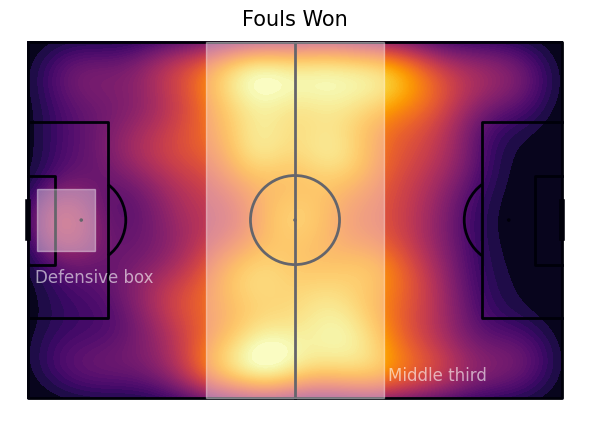

In [14]:
df_filtered = df_event.copy()

# filtering and aggregating data for Foul Won events
df_filtered = df_filtered.loc[df_filtered['type.name'] == 'Foul Won']
df_filtered['location_x'], df_filtered['location_y'] = extract_location(df_filtered['location'])  # location

# visualising
pitch = Pitch(line_color='#000009', line_zorder=2)
fig, ax = pitch.draw(figsize=(6, 8))
kde = pitch.kdeplot(df_filtered['location_x'], df_filtered['location_y'], ax=ax,
                    fill=True,
                    levels=100,
                    thresh=0,
                    cut=4,
                    cmap='inferno')


# highlighting areas
shape1 = np.array([[40, 0], [40, 80], [80, 80], [80, 0]])
shape2 = np.array([[2, 33], [15, 33], [15, 47], [2, 47]])
verts = [shape1, shape2]
pitch.polygon(verts, color='white', alpha=0.4, ax=ax, zorder=4)

txt = ax.text(x=92, y=75, s='Middle third', size=12, color='white', alpha=0.6,
              va='center', ha='center')

txt = ax.text(x=15, y=53, s='Defensive box', size=12, color='white', alpha=0.6,
              va='center', ha='center')

txt = ax.text(x=60, y=-5, s='Fouls Won', size=15, color='black', va='center', ha='center')


### Dropping unnecessary columns

In [15]:
cols_to_drop = [
    'Unnamed: 0',
    'index',
    'id',
    # 'player.id',  # maybe it would be over reliant?
    'timestamp',
    'second',
    'minute',
    'duration',  # extremely skewed
    'possession',
    'related_events',
    'location',
    'type.name',
    'possession_team.id',
    'possession_team.name',
    'play_pattern.name',
    'team.name',
    'tactics.formation',
    'tactics.lineup',
    'player.name',
    'position.name',
    'pass.height.name',
    'pass.body_part.name',
    'pass.type.name',
    'pass.outcome.name',
    'pass.outcome.id',  # Not known info at the time of ball reception or recovery
    'pass.receipient.id',
    'pass.recipient.name',
    'pass.end_location',
    'dribble.outcome.name',
    'ball_receipt.outcome.id',
    'ball_receipt.outcome.name',
    'carry.end_location',  # only nan
    'duel.outcome.name',
    'competition_id',
    'match_id',
    'poss_mini',
    'poss_mini_id',
    'valid_start',
    'relevant_related_id',
    'location_related',
    'pass.end_location_related',  # same as location for the main event
    'id_related',
    'manager_id_home',
    'manager_id_away',
    'manager_countryid_home',
    'manager_countryid_away',
    'manager_birthdate_home',
    'manager_birthdate_away',
    'manager_birthdate_opponent',
    'manager_birthdate_own',
    'pass.end_location_y',
    'pass.end_location_x',
    'location_related_y',
    'location_related_x',
    # 'pass.end_location_y_bin',  # the event might come in with this
    # 'pass.end_location_x_bin',
    'dribble.outcome.id',  # too few (2)
    'home_team.home_team_id',
    'away_team.home_team_id',
    'team.id_related',  # useful with having opponent and own team id?
    'location_x',  # with bins in it could be not relevant
    'location_y',  # with bins in it could be not relevant
    'pass.angle',  # not used to avoid None inputing
    'pass.angle_related',  # not used to avoid None inputing
]

df_training_full = df_training_full.drop(columns=cols_to_drop, errors='ignore')


### Using proper format for each columns



- Boolean columns
    - Original format is not 0, 1
- ID columns
    - These contain numbers but the models should interpret them as categories
- Rounding up
    - Some values are too detailed hence they are round up to 0 or 2 decimals

In [16]:
df_filtered = df_training_full.copy()


for col in to_boolean_cols:
    df_filtered[col] = df_filtered[col].fillna(False).astype(int)

for col in to_string_cols:
    df_filtered[col] = df_filtered[col].apply(lambda x: str(int(x)) if pd.notna(x) else np.nan)
    # df_filtered[col] = df_filtered[col].apply(lambda x: str(int(x)) if pd.notna(x) else 'NONE')

for col in to_roundup_cols:
    df_filtered[col] = df_filtered[col].round()

# for col in to_roundup2_cols:
#     df_filtered[col] = df_filtered[col].round(2)

df_training_full = df_filtered.copy()

In [17]:
# reordering columns to have contains_foulwon at the front
columns = ['contains_foulwon'] + [col for col in df_training_full.columns if col != 'contains_foulwon']
df_training_full = df_training_full[columns]

In [18]:
df_training_full.shape


(502152, 42)

In [19]:
df_training_full.to_csv('/Users/thomasregos/Owny/Assessment/Swish_Take_Home_Assessment_Data_-_EPL/Output/training_data.csv', index=False)

# Modeling

In [20]:
df_input = pd.read_csv('/Users/thomasregos/Owny/Assessment/Swish_Take_Home_Assessment_Data_-_EPL/Output/training_data.csv')

df_filtered = df_input.copy()

for col in to_boolean_cols:
    df_filtered[col] = df_filtered[col].fillna(False).astype(int)

for col in to_string_cols:
    df_filtered[col] = df_filtered[col].apply(lambda x: str(int(x)) if pd.notna(x) else np.nan)
    # df_filtered[col] = df_filtered[col].apply(lambda x: str(int(x)) if pd.notna(x) else 'NONE')

for col in to_roundup_cols:
    df_filtered[col] = df_filtered[col].apply(lambda x: round(x) if pd.notna(x) else 0)

# for col in to_roundup2_cols:
#     df_filtered[col] = df_filtered[col].round(2)

df_input = df_filtered.copy()

## Independent variables

### Distributions

Let's assess the distribution of each variable accounting for the fact that the event was followed by a won foul or not.

Most of the variables that we eneded up with have a difference visually. However, there are some, where the difference seems to be negligible. Later I will pay extra attention to some of these when assessing their importance in the models. 'pass.type.id' contained '66' as valid value and only one time a different one so I converted is to be a bool column.

There are several variables that back intuition:
- If the event is under pressure than the probability is higher to win a foul
- There are less fouls won in the opening minutes of the games compared to no foul mini possessions
- There is a higher probability of winning a foul in the middle third
- If the event is a pass and it is with the right foot there is a higher probability of resulting in a foul won than for example with a pass that was a header. The intuition behind this is that a pass with the (usually) stronger foot is more precise, more dangerous hence has a higher chance to provoke a foul than a header.
- There are teams that win less fouls than expected based on the number of their mini possessions. The two teams that dive the less or the referess dislike the most is Norwich and Liverpool.
- If a player won a duel it is highly likely that he will be fouled (duel.outcome.id == 4)

Interestingly there is more possibility to win a foul outside the defensive box than inside. I suspect that the local maximum can still be a good indicator even tough globally that probability is not higher than for example in the middle third.

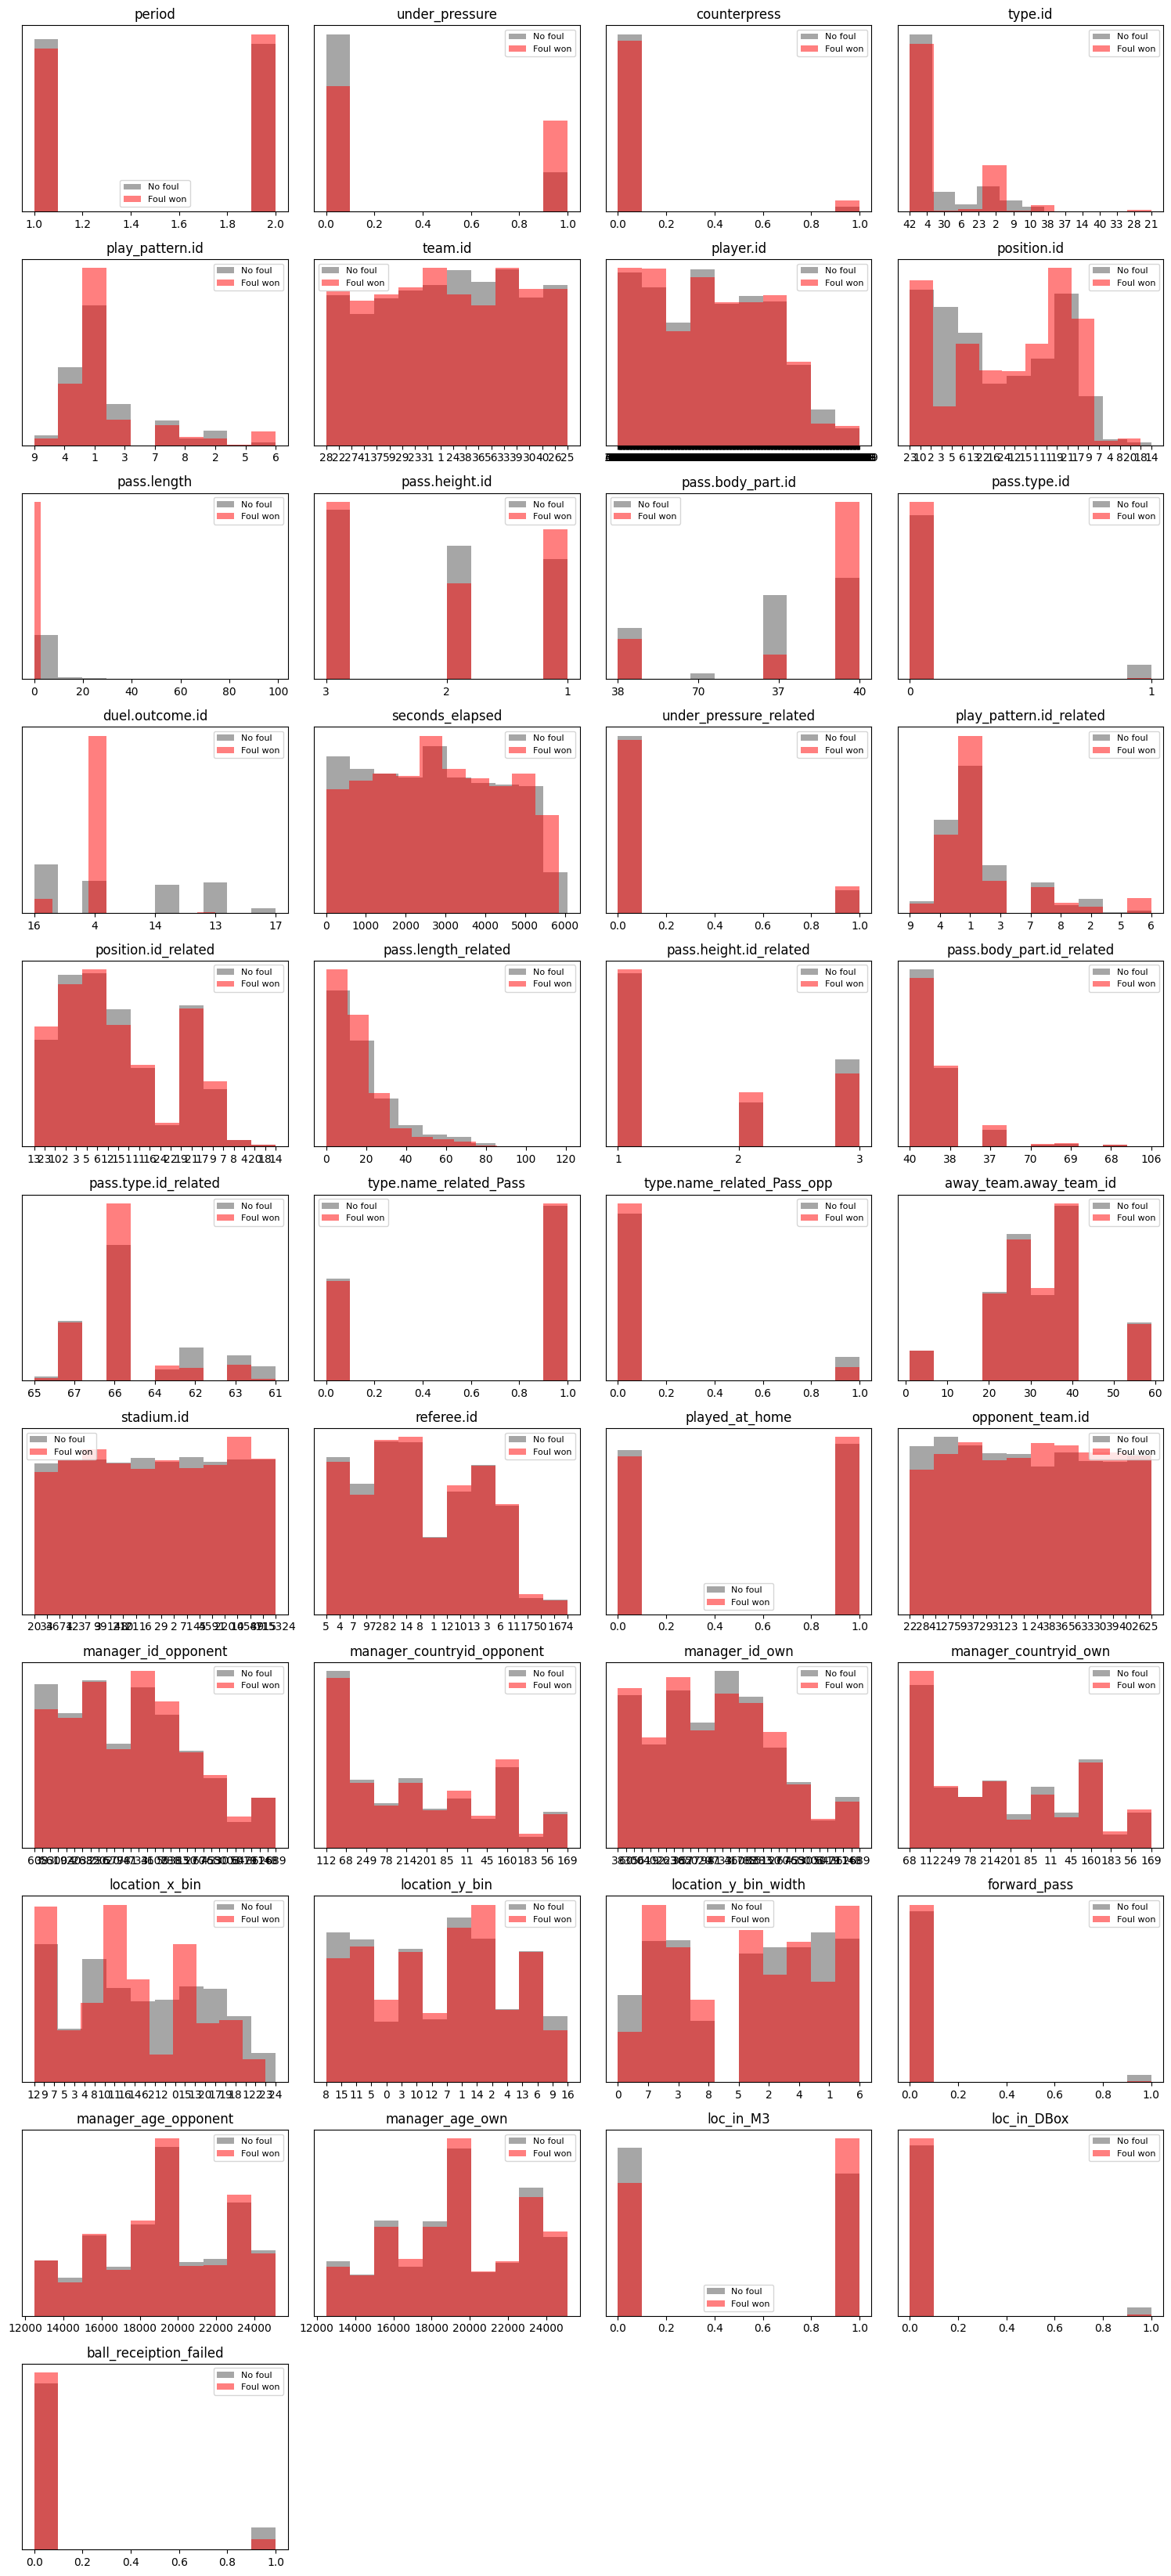

In [21]:
df_visu = df_input.copy()

for col in to_string_cols:
    df_visu[col] = df_visu[col].apply(lambda x: str(int(x)) if pd.notna(x) else 'NONE')

plot_histograms_grid(df_visu, 'contains_foulwon')

In [22]:
# pass.type.id

df_filtered = df_input.copy()

pass_typids = df_filtered['pass.type.id'].value_counts()
pass_typeid_66 = df_filtered[df_filtered['pass.type.id'] == '66']['contains_foulwon'].value_counts()

print(f"Only one event contains pass.type.id == 61: {pass_typids}")

Only one event contains pass.type.id == 61: pass.type.id
0    463153
1     38999
Name: count, dtype: int64


In [23]:
# Teams winning less fouls then expected

df_filtered = df_event.copy()
df_teams = df_filtered.groupby(['team.id'], as_index=False)[['team.name']].first()
df_teams['team.id'] = df_teams['team.id'].astype(str)

df_filtered = df_input.copy()

df_filtered = df_filtered.groupby(['team.id'], as_index=False).agg(
    foulwon_ratio = ('contains_foulwon', lambda x: x.sum() / x.count())
).sort_values('foulwon_ratio')

df_filtered = df_filtered.merge(df_teams, on='team.id')
df_filtered

,team.id,foulwon_ratio,team.name
0,56,0.011333,Norwich City
1,24,0.011362,Liverpool
2,39,0.011872,Manchester United
3,36,0.012086,Manchester City
4,38,0.012369,Tottenham Hotspur
5,25,0.012854,Southampton
6,30,0.013184,Stoke City
7,28,0.013474,AFC Bournemouth
8,29,0.013762,Everton
9,37,0.013838,Newcastle United


### Correlation matrix

Fortunately there seems to be not too much correlation between the variables.

- Seconds elapsed and period naturally correlates a lot
- Forward pass, pass height and length also correlates

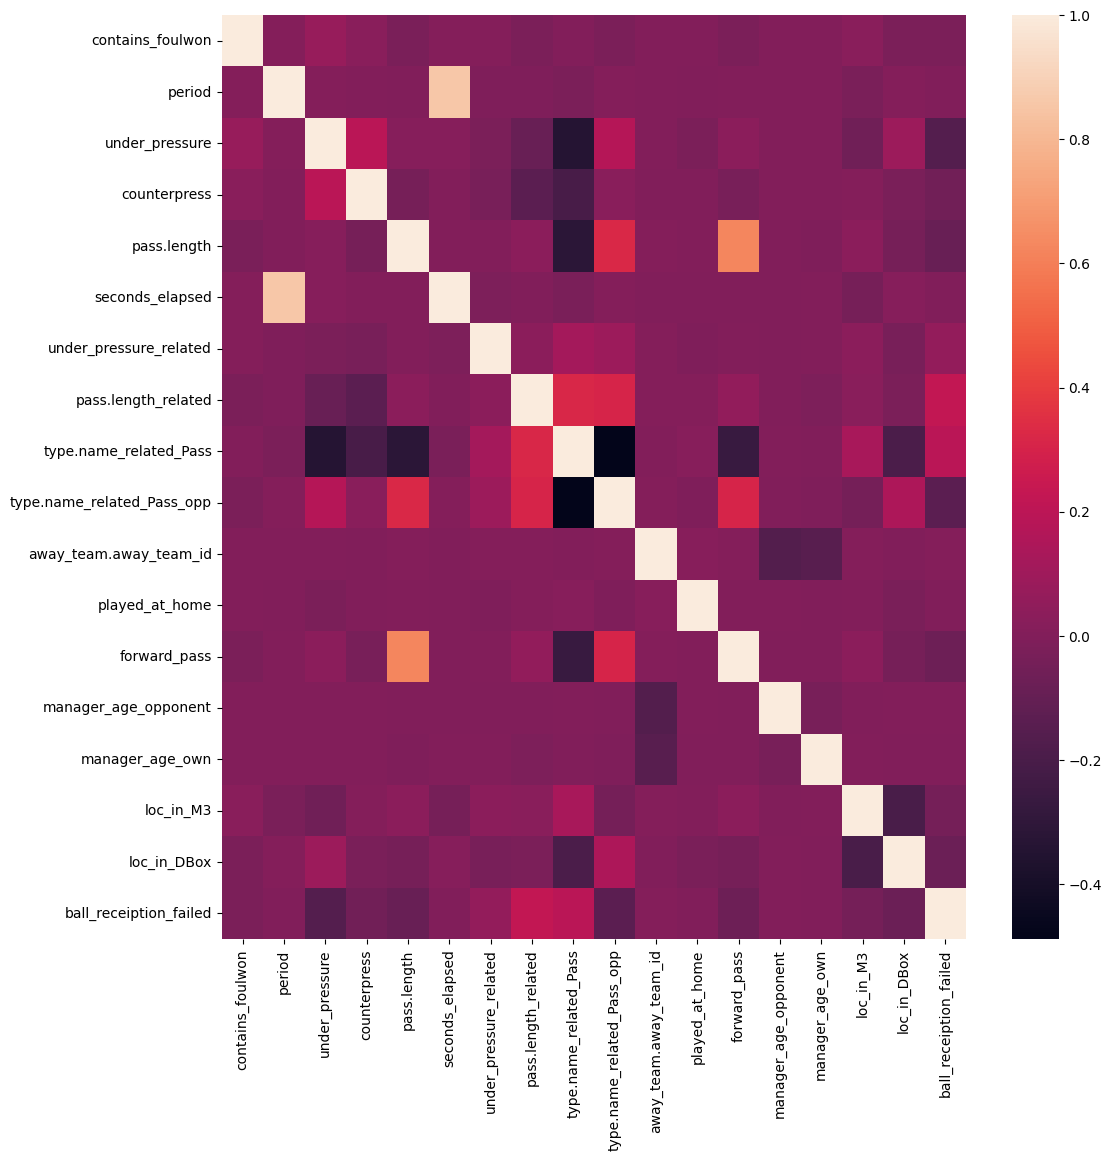

In [24]:
df_filtered = df_input.copy()
num_cols = df_input.select_dtypes(include=['number']).columns.tolist()

df_filtered = df_filtered[num_cols]

df_filtered = df_filtered.corr()

plt.figure(figsize = (12,12))

ax = sns.heatmap(df_filtered,
        xticklabels=df_filtered.columns,
        yticklabels=df_filtered.columns)

### Log and standardizing

- Standardizing is applied to the numerical variables to bring them closer in terms of scale.

- As earlier was mentioned the pass length is heavily skewed so taking the log of it makes it more like a gaussian distribution which is better to use for modeling.

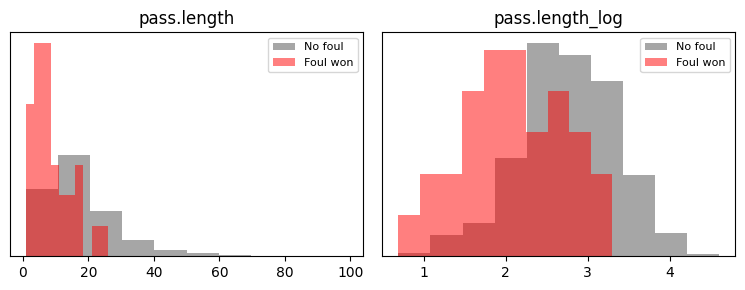

In [25]:
df_filtered = df_input.copy()
df_filtered = df_filtered[df_filtered['pass.length']!=0]
df_filtered = df_filtered[['contains_foulwon', 'pass.length']]
df_filtered['pass.length_log'] = np.log(df_filtered['pass.length'] + 1)

plot_histograms_grid(df_filtered, 'contains_foulwon', bins=10)

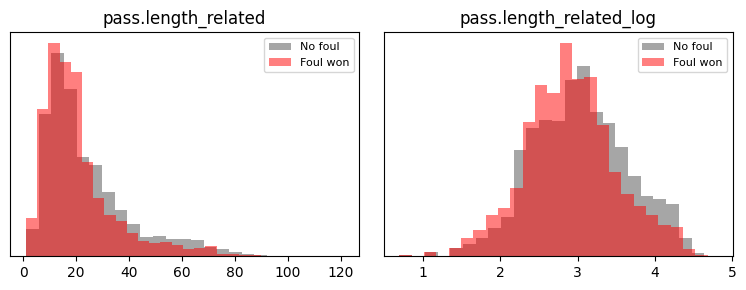

In [26]:
df_filtered = df_input.copy()
df_filtered = df_filtered[df_filtered['pass.length_related']!=0]
df_filtered = df_filtered[['contains_foulwon', 'pass.length_related']]
df_filtered['pass.length_related_log'] = np.log(df_filtered['pass.length_related'] + 1)

plot_histograms_grid(df_filtered, 'contains_foulwon', bins=25)

In [27]:

df_filtered = df_input.copy()

# Stand
cols_to_standardize = [
    'seconds_elapsed',
    'manager_age_opponent',
    'manager_age_own'
]


# Initialize the scaler
scaler = StandardScaler()
df_filtered[cols_to_standardize] = scaler.fit_transform(df_filtered[cols_to_standardize])

# Log
cols_to_log = [
    'pass.length',
    'pass.length_related',
]
for col in cols_to_log:
    df_filtered[col] = np.log(df_filtered[col] + 1)

df_input = df_filtered.copy()


### One hot encoding categorical variables

In [28]:
# Converting categorical variables to bool columns to get rid of nans

df_filtered = df_input.copy()

# df_filtered = resample(df_filtered, replace=False, n_samples=round(len(df_filtered)*0.5), random_state=42)


# Initialize OneHotEncoder
OHEncoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')

# Fit on multiple columns
df_filtered_encoded = OHEncoder.fit_transform(df_filtered[categorical_cols])
df_filtered_encoded = pd.DataFrame(df_filtered_encoded, columns=OHEncoder.get_feature_names_out(categorical_cols))
df_filtered_encoded = df_filtered_encoded.drop(columns=[col for col in df_filtered_encoded.columns if 'nan' in col])

df_filtered = df_filtered[numerical_cols]
df_filtered = pd.concat([df_filtered, df_filtered_encoded], axis=1)

df_filtered = df_filtered.rename(columns={'contains_foulwon_1': 'contains_foulwon'})

df_filtered = df_filtered.fillna(0)

df_input = df_filtered.copy()

## Target variable

Our target variable is a boolean, which represents if during the mini possession there was a foul won by the player or not. As winning a foul is quite rare the data is heavily imbalanced.

I dont want to use feature selection here which is base upon modeling the target variable.

In [29]:
df_filtered = df_input.copy()
foulwon_ratio = df_filtered.loc[df_filtered['contains_foulwon'] == 1]['contains_foulwon'].sum() / len(df_filtered['contains_foulwon'])
print(f"Only {round(foulwon_ratio, 4)*100}% of the mini possession ends up with a foul won.")


Only 1.37% of the mini possession ends up with a foul won.


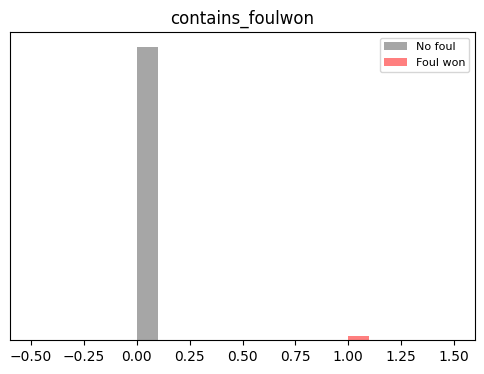

In [30]:
df_filtered = df_input.copy()
df_filtered = df_filtered[['contains_foulwon']]
plot_histogram_one(df_filtered, 'contains_foulwon')

### Train-test split

Only the training data will be up and down sampled.

In [57]:
df_filtered = df_input.copy()


x_main = df_filtered.drop(columns=['contains_foulwon'])
y_main = df_filtered['contains_foulwon']

X_train, X_test, y_train, y_test = train_test_split(x_main, y_main, test_size = 0.2, random_state = 42)

### Oversampling the minority class

I dont want to introduce hybrid values so I wont use methods like SMOTE.


In [58]:
df_filtered = X_train.copy()
df_filtered['contains_foulwon'] = y_train
df_filtered = df_filtered[df_filtered['contains_foulwon'] == 1]

# Oversampling minority class
df_minority_oversampled = resample(df_filtered, replace=True, n_samples=round(len(df_input)*0.1), random_state=42)



### Undersampling the majority class

In [59]:
df_filtered = X_train.copy()
df_filtered['contains_foulwon'] = y_train
df_filtered = df_filtered[df_filtered['contains_foulwon'] == 0].drop(columns='contains_foulwon')

print(f'Length of data: {df_filtered.shape[0]}')

# Fitting UMAP on the smaller sample
df_sample = resample(df_filtered, replace=False, random_state=42,
                     n_samples=round(len(df_filtered)*0.6))

print(f'Length of training data: {df_sample.shape[0]}')
reducer = UMAP(
    random_state=42,
    n_components=2,
    n_neighbors=50,
    min_dist=0.2,
    metric='euclidean',
    n_jobs=-1,
    low_memory=False,
    )
reducer.fit(df_sample)
print('Fitting has finished ..')

# Transforming all the samples
df_reduced = pd.DataFrame(reducer.transform(df_filtered), index=df_filtered.index)

Length of data: 396216
Length of training data: 237730
Fitting has finished ..


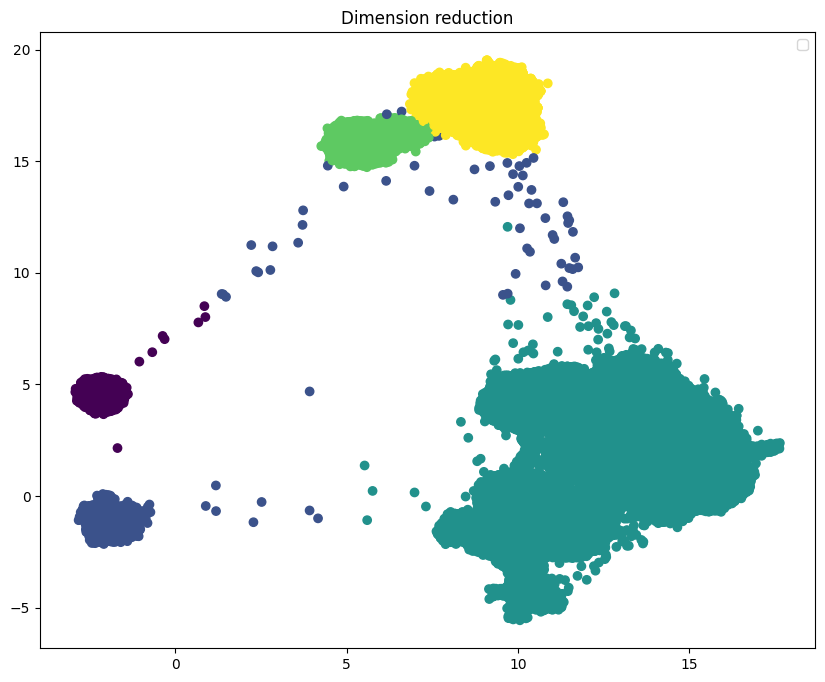

In [60]:
df_reduced = df_reduced.copy()


clustering = HDBSCAN(gen_min_span_tree=True,
                     min_cluster_size=2000,
                     min_samples=100,
                     cluster_selection_epsilon=0.4,
                     metric='euclidean'
                     ).fit(df_reduced)
df_reduced["CLUSTER"] = abs(clustering.labels_)


# Plotting
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_reduced[0], df_reduced[1],
                      c=df_reduced['CLUSTER'],
                      cmap='viridis')
# plt.colorbar(scatter)  # Show the color bar
plt.legend()
plt.title('Dimension reduction')
plt.show()

In [61]:
df_reduced["CLUSTER"].value_counts()

CLUSTER
2    282124
4     58116
3     24899
1     16677
0     14400
Name: count, dtype: int64

In [167]:
df_filtered = df_reduced.copy()


# Leaving 50% of the largest cluster
cluster_to_sample = [2]
df_filtered_clusters_big = df_filtered[df_filtered['CLUSTER'].isin(cluster_to_sample)]
df_filtered_clusters_big = resample(df_filtered_clusters_big, replace=False, random_state=42,
                                   n_samples=round(len(df_filtered_clusters_big)*0.3))

# Leaving 75% of the largest clusters
cluster_to_sample = [4]
df_filtered_clusters_mid = df_filtered[df_filtered['CLUSTER'].isin(cluster_to_sample)]
df_filtered_clusters_mid = resample(df_filtered_clusters_mid, replace=False, random_state=42,
                                   n_samples=round(len(df_filtered_clusters_mid)*0.85))

# Leavin 90% of the smaller clusters
cluster_to_sample = [3, 2, 1]
df_filtered_clusters_s = df_filtered[~df_filtered['CLUSTER'].isin(cluster_to_sample)]
df_filtered_clusters_s = resample(df_filtered_clusters_s, replace=False, random_state=42,
                                     n_samples=round(len(df_filtered_clusters_s)*0.95))

# getting all the

selected_indexes = pd.concat([df_filtered_clusters_big, df_filtered_clusters_mid, df_filtered_clusters_s]).index

# Filtering the majority class dataset based on sampled indexes
df_filtered = df_input.copy()
df_filtered = df_filtered[df_filtered['contains_foulwon'] == 0]
df_filtered = df_filtered.loc[selected_indexes]

df_majority_undersampled = df_filtered.copy()



### Uniting sampled data

In [168]:
df_sampled = pd.concat([df_minority_oversampled, df_majority_undersampled], ignore_index=True)


In [169]:
df_filtered = df_sampled.copy()
foulwon_ratio = df_filtered.loc[df_filtered['contains_foulwon'] == 1]['contains_foulwon'].sum() / len(df_filtered['contains_foulwon'])
print(f"Only {round(foulwon_ratio, 4)*100}% of the mini possession ends up with a foul won.")

Only 19.84% of the mini possession ends up with a foul won.


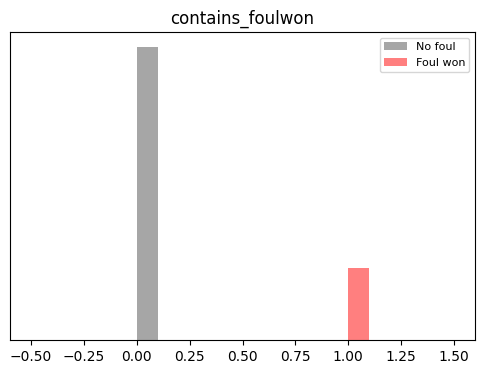

In [170]:
df_filtered = df_sampled.copy()
df_filtered = df_filtered[['contains_foulwon']]
plot_histogram_one(df_filtered, 'contains_foulwon')

In [66]:
df_sampled.to_csv('/Users/thomasregos/Owny/Assessment/Swish_Take_Home_Assessment_Data_-_EPL/Output/training_sampled.csv', index=False)

### Redefining X_train and y_train

In [171]:
X_train = df_sampled.drop(columns=['contains_foulwon'])
y_train = df_sampled['contains_foulwon']

### Addressing class imbalance

Used techniques:
- Resampling the minority class
- Undersampling the majority class
- Using log loss (cross entropy) as evaluation metric
- Threshold tuning to be less than 0.5
- Class weighting


## Building models

In [172]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrices(true_vals_1, predicted_vals_1, true_vals_2, predicted_vals_2, labels=("Model 1", "Model 2")):
    """
    Plots two confusion matrices side by side.

    Parameters:
    - true_vals_1, predicted_vals_1: Ground truth and predictions for the first model.
    - true_vals_2, predicted_vals_2: Ground truth and predictions for the second model.
    - labels: Tuple of titles for each confusion matrix.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

    # First confusion matrix
    ConfusionMatrixDisplay.from_predictions(true_vals_1, predicted_vals_1, 
                                            normalize='true', values_format=".0%", ax=axes[0])
    axes[0].set_title(labels[0])

    # Second confusion matrix
    ConfusionMatrixDisplay.from_predictions(true_vals_2, predicted_vals_2, 
                                            normalize='true', values_format=".0%", ax=axes[1])
    axes[1].set_title(labels[1])

    plt.tight_layout()
    plt.show()




## Splitting test data

SPlitting test data to test and validation

In [173]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.25, random_state=42, stratify=y_test)

### Base model

Using a the average ratio for predicting if a mini possession will contain foul won or not.

As expected it will classify all mini possession as non-containing, even with a lower than 0.5 threshold. If the threshold would be too low than it would falsely classify all as a containing (foul won) mini possession.

Training score: 0.4981312432612483
Test score: 0.240674441648045
Weighted RMSE: 0.5839366742273112


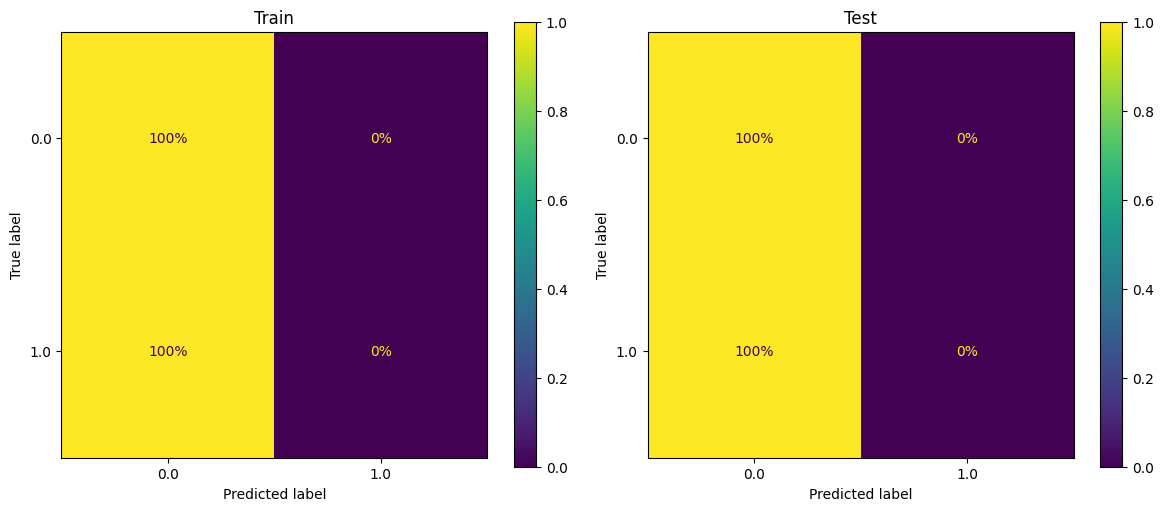

In [209]:

df_filtered = df_sampled.copy()

foulwon_ratio = df_filtered.loc[df_filtered['contains_foulwon'] == 1]['contains_foulwon'].sum() / len(df_filtered['contains_foulwon'])

y_train_pred = np.full_like(y_train, fill_value=foulwon_ratio, dtype=float)
y_test_pred = np.full_like(y_test, fill_value=foulwon_ratio, dtype=float)

threshold = 0.5
y_train_pred_binary = (y_train_pred >= threshold).astype(int)
y_test_pred_binary = (y_test_pred >= threshold).astype(int)


score_train = log_loss(y_train, y_train_pred)
score_test = log_loss(y_test, y_test_pred)

print(f'Training score: {score_train}\nTest score: {score_test}')




# Compute class weights: Inverse of class frequency
class_counts = y_test.value_counts().values  # Count occurrences of each class (0 and 1)
total_samples = len(y_test)
class_weights = {cls: total_samples / (len(class_counts) * count) for cls, count in enumerate(class_counts)}

# Assign sample weights based on class labels
sample_weights = np.array([class_weights[label] for label in y_test])

# Compute weighted RMSE
weighted_mse = mean_squared_error(y_test, y_test_pred, sample_weight=sample_weights)
weighted_rmse = np.sqrt(weighted_mse)

print(f'Weighted RMSE: {weighted_rmse}')


plot_confusion_matrices(y_train, y_train_pred_binary, y_test, y_test_pred_binary, labels=['Train', 'Test'])




### Random Forest

This is perfectly over trains itself, so the performance on test dataset is still not good, however at least not classifies all the mini possession to not contain foul won.

Training score: 0.010852355143485079
Test score: 0.40174027661906025


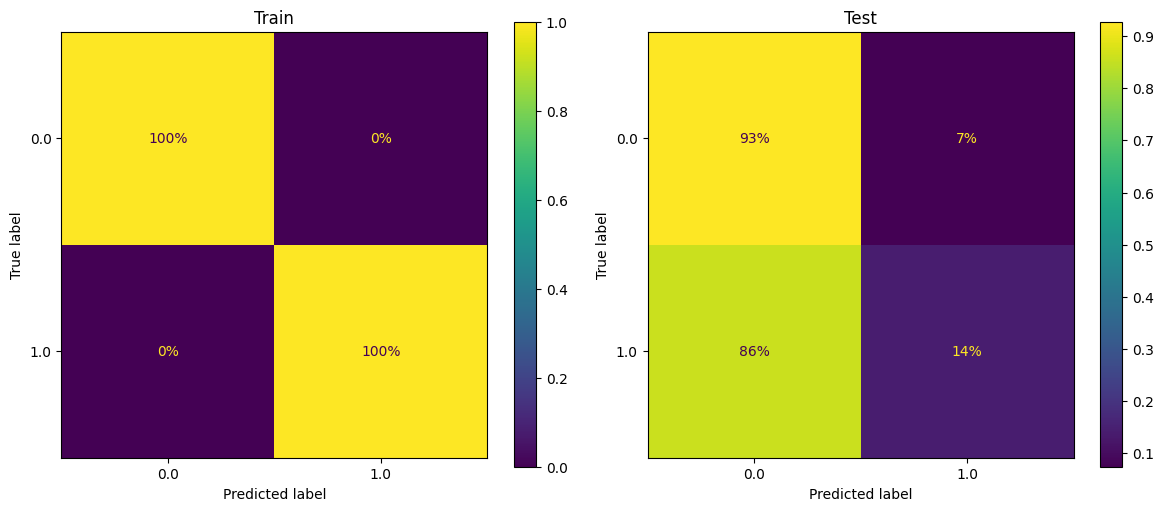

0.058397086570743335

In [132]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
importances = rf_classifier.feature_importances_

# Predict probabilities for the positive class (class = 1)
y_train_pred = rf_classifier.predict_proba(X_train)[:, 1]
y_test_pred = rf_classifier.predict_proba(X_test)[:, 1]

threshold = 0.3
y_train_pred_binary = (y_train_pred >= threshold).astype(int)
y_test_pred_binary = (y_test_pred >= threshold).astype(int)

score_train = log_loss(y_train, y_train_pred)
score_test = log_loss(y_test, y_test_pred)
print(f'Training score: {score_train}\nTest score: {score_test}')

plot_confusion_matrices(y_train, y_train_pred_binary, y_test, y_test_pred_binary, labels=['Train', 'Test'])

mean_squared_error(y_test, y_test_pred)

### XGBoost

#### Without splitting into folds

Training score: 0.13075536530763
Test score: 0.6358132160563387


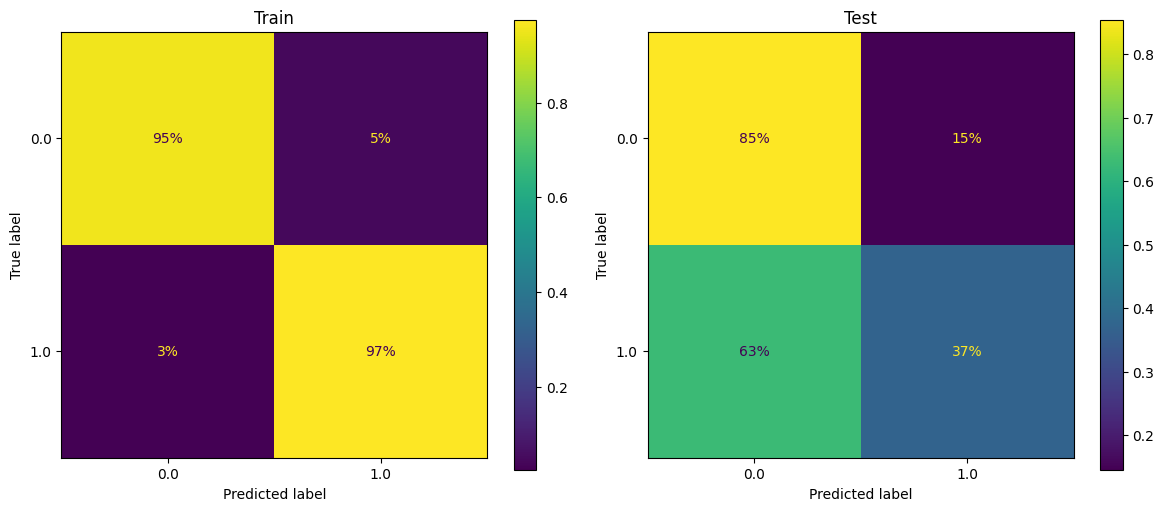

In [156]:


binary_threshold = 0.35

scale_pos_weight = len(y_train) / (3.7 * np.sum(y_train == 1)) 
# scale_pos_weight = len(y_train) / (3.7 * np.sum(y_train == 1)) 
xgboostclassifier = XGBClassifier(
    random_state=42, n_jobs=-1,
    learning_rate=0.5,
    n_estimators=220,
    max_depth=7,
    scale_pos_weight=scale_pos_weight, 
    )


xgboostclassifier.fit(X_train, y_train)
importances = xgboostclassifier.feature_importances_

# Prediction
y_train_pred = xgboostclassifier.predict_proba(X_train)[:, 1]
y_test_pred = xgboostclassifier.predict_proba(X_test)[:, 1]

# Converting to 0, 1
y_train_pred_binary = (y_train_pred >= binary_threshold).astype(int)
y_test_pred_binary = (y_test_pred >= binary_threshold).astype(int)

# evaluation
score_train = log_loss(y_train, y_train_pred)
score_test = log_loss(y_test, y_test_pred)
print(f'Training score: {score_train}\nTest score: {score_test}')

plot_confusion_matrices(y_train, y_train_pred_binary, y_test, y_test_pred_binary, labels=['Train', 'Test'])

In [221]:
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from xgboost import XGBClassifier
from sklearn.metrics import log_loss, f1_score
from functools import partial


class_counts = y_val.value_counts().values  # Count occurrences of each class (0 and 1)
total_samples = len(y_val)
class_weights = {cls: total_samples / (len(class_counts) * count) for cls, count in enumerate(class_counts)}

# Assign sample weights based on class labels
sample_weights = np.array([class_weights[label] for label in y_val])



# Define hyperparameter search space
search_space = [
    Real(0.1, 0.3, name="learning_rate"),
    Integer(200, 350, name="n_estimators"),
    Integer(10, 13, name="max_depth"),
]

# Objective function for Bayesian Optimization
@use_named_args(search_space)
def objective(learning_rate, n_estimators, max_depth):
    params = {
        "learning_rate": learning_rate,
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "scale_pos_weight": len(y_train) / (3.7 * sum(y_train == 1)),  # Adjust for imbalance
        "random_state": 42,
        "n_jobs": -1,
    }

    # Train XGBoost model
    xgboostclassifier = XGBClassifier(**params)
    xgboostclassifier.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    # Predict probabilities on validation set
    y_val_pred = xgboostclassifier.predict_proba(X_val)[:, 1]

    # Compute Log Loss (to minimize)
    return log_loss(y_val, y_val_pred, normalize=True, sample_weight=sample_weights)


res = gp_minimize(objective, search_space, n_calls=30, random_state=42, n_jobs=-1)
best_params = dict(zip(["learning_rate", "n_estimators", "max_depth"], res.x))
print(f"Best Parameters: {best_params}")


Best Parameters: {'learning_rate': 0.1, 'n_estimators': np.int64(200), 'max_depth': np.int64(10)}


Final Test Log Loss: 0.6414420238879672


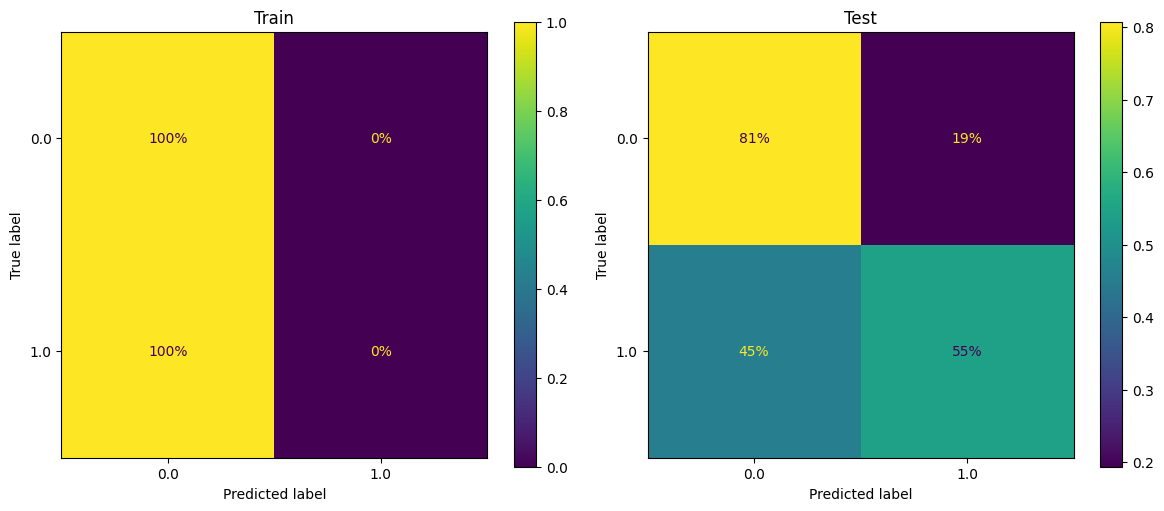

In [225]:
xgboostclassifier_best = XGBClassifier(**best_params, scale_pos_weight=len(y_train) / (3.7 * sum(y_train == 1)), 
                                       random_state=42, n_jobs=-1)

xgboostclassifier_best.fit(X_train, y_train)

binary_threshold = 0.25

# Evaluate on Test Set
y_test_pred = xgboostclassifier_best.predict_proba(X_test)[:, 1]
final_log_loss = log_loss(y_test, y_test_pred)
print(f"Final Test Log Loss: {final_log_loss}")


y_train_pred_binary = (y_train_pred >= binary_threshold).astype(int)
y_test_pred_binary = (y_test_pred >= binary_threshold).astype(int)
plot_confusion_matrices(y_train, y_train_pred_binary, y_test, y_test_pred_binary, labels=['Train', 'Test'])

In [226]:

# Compute class weights: Inverse of class frequency
class_counts = y_test.value_counts().values  # Count occurrences of each class (0 and 1)
total_samples = len(y_test)
class_weights = {cls: total_samples / (len(class_counts) * count) for cls, count in enumerate(class_counts)}

# Assign sample weights based on class labels
sample_weights = np.array([class_weights[label] for label in y_test])

# Compute weighted RMSE
weighted_mse = mean_squared_error(y_test, y_test_pred, sample_weight=sample_weights)
weighted_rmse = np.sqrt(weighted_mse)

print(f'Weighted RMSE: {weighted_rmse}')

Weighted RMSE: 0.5385121548492611


### As regression with sigmoid

In [227]:
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import log_loss, f1_score
from functools import partial


def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class_counts = y_val.value_counts().values  # Count occurrences of each class (0 and 1)
total_samples = len(y_val)
class_weights = {cls: total_samples / (len(class_counts) * count) for cls, count in enumerate(class_counts)}

# Assign sample weights based on class labels
sample_weights = np.array([class_weights[label] for label in y_val])



# Define hyperparameter search space
search_space = [
    Real(0.1, 0.3, name="learning_rate"),
    Integer(200, 350, name="n_estimators"),
    Integer(10, 13, name="max_depth"),
]

# Objective function for Bayesian Optimization
@use_named_args(search_space)
def objective(learning_rate, n_estimators, max_depth):
    params = {
        "learning_rate": learning_rate,
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "scale_pos_weight": len(y_train) / (3.7 * sum(y_train == 1)),  # Adjust for imbalance
        "random_state": 42,
        "n_jobs": -1,
    }

    # Train XGBoost model
    xgboostclassifier = XGBRegressor(**params)
    xgboostclassifier.fit(X_train, y_train)

    # Predict probabilities on validation set
    y_val_pred = sigmoid(xgboostclassifier.predict(X_val))

    # Compute Log Loss (to minimize)
    return log_loss(y_val, y_val_pred, normalize=True, sample_weight=sample_weights)


res = gp_minimize(objective, search_space, n_calls=30, random_state=42, n_jobs=-1)
best_params = dict(zip(["learning_rate", "n_estimators", "max_depth"], res.x))
print(f"Best Parameters: {best_params}")


Best Parameters: {'learning_rate': 0.29996077773835284, 'n_estimators': np.int64(293), 'max_depth': np.int64(10)}


Final Test Log Loss: 0.7606574095594621
Weighted RMSE: 0.4850412521079424


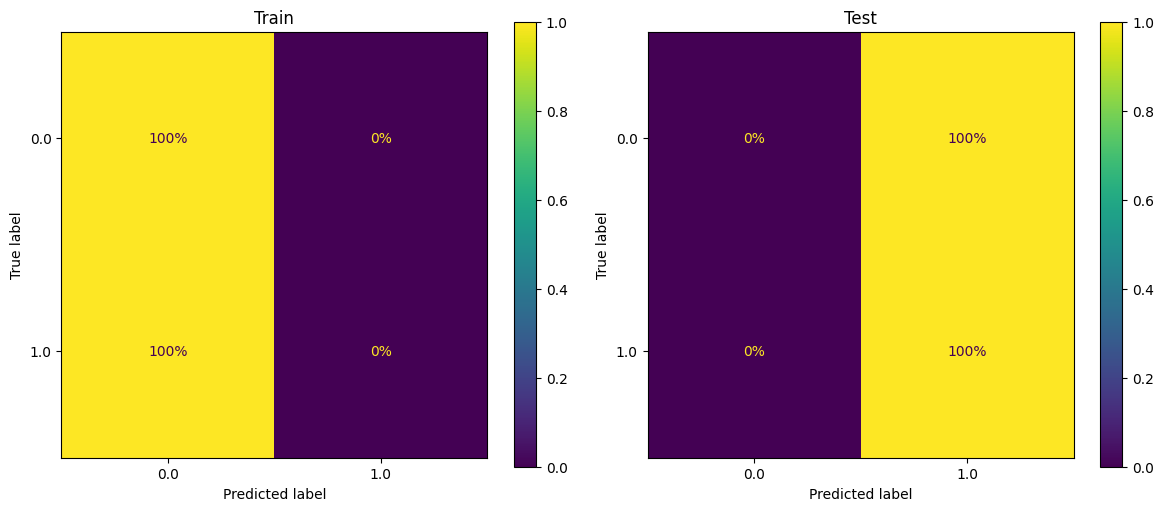

In [231]:
xgboostclassifier_best = XGBRegressor(**best_params, scale_pos_weight=len(y_train) / (3.7 * sum(y_train == 1)), 
                                      random_state=42, n_jobs=-1)

xgboostclassifier_best.fit(X_train, y_train)

binary_threshold = 0.25

# Evaluate on Test Set
y_test_pred = sigmoid(xgboostclassifier_best.predict(X_test))
final_log_loss = log_loss(y_test, y_test_pred)
print(f"Final Test Log Loss: {final_log_loss}")


# Compute class weights: Inverse of class frequency
class_counts = y_test.value_counts().values  # Count occurrences of each class (0 and 1)
total_samples = len(y_test)
class_weights = {cls: total_samples / (len(class_counts) * count) for cls, count in enumerate(class_counts)}

# Assign sample weights based on class labels
sample_weights = np.array([class_weights[label] for label in y_test])

# Compute weighted RMSE
weighted_mse = mean_squared_error(y_test, y_test_pred,
                                  sample_weight=sample_weights
                                  )
weighted_rmse = np.sqrt(weighted_mse)

print(f'Weighted RMSE: {weighted_rmse}')


y_train_pred_binary = (y_train_pred >= binary_threshold).astype(int)
y_test_pred_binary = (y_test_pred >= binary_threshold).astype(int)
plot_confusion_matrices(y_train, y_train_pred_binary, y_test, y_test_pred_binary, labels=['Train', 'Test'])

array([0.50253105, 0.48891607, 0.50488704, ..., 0.52943546, 0.58336264,
       0.49587452], shape=(1570,), dtype=float32)

# Notes MAGYARUL

- Lehet RMSE-vel kéne kiértékelni a végén de nem azzal tanítani?
- Olyan metrika ami a true positiveot díjazza
- Kiemelni konkrétan azt ami a true positivok arányát méri
- A regressor nem néz ki túl jól, annak ellenére hogy jobb RMSE-t hoz én maradnék a classificatornal